# 元胞自动机 Cellular Automata

xyfJASON

## 1 理论

元胞自动机的思想很简单，在一个 $n$ 维网格内有一些元胞，每个元胞可以取有限种状态，给定状态转换的规则（依赖于元胞当前状态和邻居当前状态），则在下一个时刻，元胞们依据规则转换状态，就构成了一个元胞自动机。

一些经典的元胞自动机：

- 生命游戏：二维平面，每个细胞两种状态——生/死，下一时刻的状态受其周围 $8$ 个细胞的状态而定：
  1. 如果一个细胞周围有 $3$ 个细胞为生，则该细胞为生；
  2. 如果一个细胞周围有 $2$ 个细胞为生，则该细胞的生死状态保持不变；
  3. 在其它情况下，该细胞为死。
- NaSch：一维模拟车辆交通模型。每个位置有两种状态——有车/无车，每辆车具有位置 $x$ 和速度 $v$ 两个属性，$v\in[0, v_\max]$，更新规则为：
  1. 加速：$v_n\gets \min(v_{n}+1,\,v_\max)$
  2. 减速：$v_n\gets\min(v_n,\,x_{n+1}-x_n-1)$，保证不碰撞
  3. 随机慢化：以概率 $p$ 慢化，$v_n\gets \max(v_n-1, 0)$
  4. 位置更新：$x_n\gets x_n+v_n$

## 2 代码模板

$2$ 维网格：

In [1]:
from abc import ABC
import numpy as np
import matplotlib.pyplot as plt


class CellularAutomata2D:
    """
    To use cellular automata in 2D space, inherit this class,
    then override one of `next_state_global` and `next_state_single_cell`.
    Override `gen_init_state` if random binary initialization is not desired.
    """
    def __init__(self, sz_grid: tuple[int, int]) -> None:
        assert len(sz_grid) == 2
        self.sz_grid = sz_grid

    def gen_init_state(self) -> np.ndarray:
        """ Generate initial state
        Generate binary code randomly by default, override if needed.
        """
        return np.random.randint(0, 2, size=self.sz_grid)

    def next_state_global(self, cur_state: np.ndarray) -> np.ndarray:
        """ Return next state of all cells directly """
        raise NotImplementedError

    def next_state_single_cell(self, cur_state: np.ndarray, pos: tuple[int, int] or int) -> int:
        """ Return next state of the single cell at `pos` """
        raise NotImplementedError

    def run(self, max_iters: int = 10, pause_time: float = 0.1) -> None:
        state = self.gen_init_state()
        assert state.shape == self.sz_grid
        for it in range(max_iters):
            ploty, plotx = np.nonzero(state)
            ploty = self.sz_grid[0] - 1 - ploty
            plt.plot(plotx, ploty, 'sk')
            plt.xticks([]); plt.yticks([])
            plt.axis([-0.5, self.sz_grid[1]+0.5, -0.5, self.sz_grid[0] + 0.5])
            plt.xlabel('time step: %d' % it)
            plt.pause(pause_time)
            plt.cla()
            try:
                state = self.next_state_global(state)
            except NotImplementedError:
                next_state = state.copy()
                for i in range(self.sz_grid[0]):
                    for j in range(self.sz_grid[1]):
                        next_state[i, j] = self.next_state_single_cell(state, (i, j))
                state = next_state

$1$ 维网格（继承 $2$ 维网格实现）：

In [2]:
class CellularAutomata1D(CellularAutomata2D, ABC):
    """
    Cellular automata in 1D space, inherited from 2D form.
    """
    def __init__(self, sz_grid: int) -> None:
        super().__init__((1, sz_grid))
        self.sz_grid = sz_grid

    def run(self, max_iters: int = 10, pause_time: float = 0.1) -> None:
        state = self.gen_init_state()
        assert state.shape[0] == self.sz_grid
        for it in range(max_iters):
            plotx = np.nonzero(state)[0]
            plt.plot(plotx, np.zeros(plotx.shape[0]), 'sk')
            plt.xticks([]); plt.yticks([])
            plt.axis([-0.5, self.sz_grid+0.5, -0.5, 0.5])
            plt.xlabel('time step: %d' % it)
            plt.pause(pause_time)
            plt.cla()
            try:
                state = self.next_state_global(state)
            except NotImplementedError:
                next_state = state.copy()
                for i in range(self.sz_grid):
                    next_state[i] = self.next_state_single_cell(state, i)
                state = next_state

## 3 例题

### 3.1 例一——生命游戏

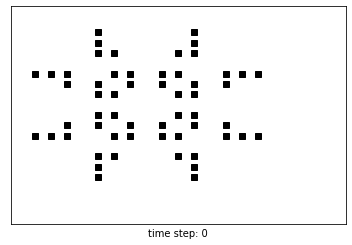

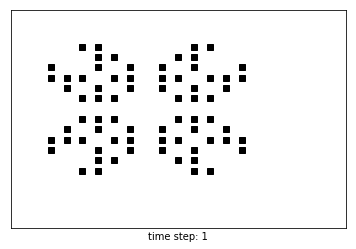

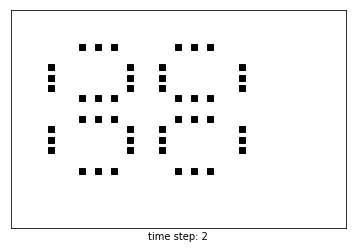

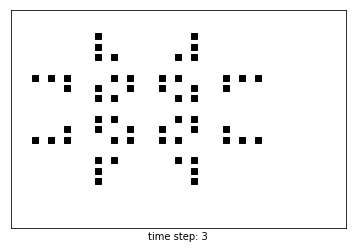

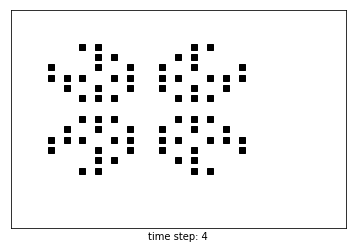

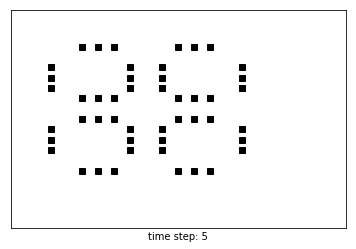

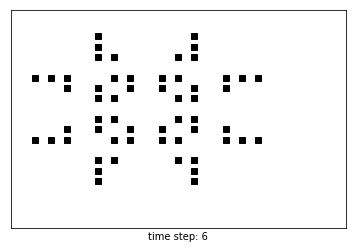

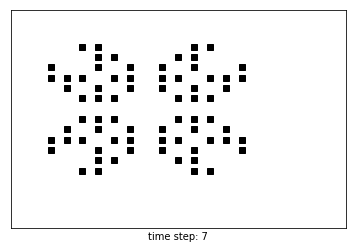

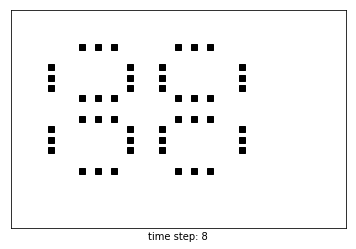

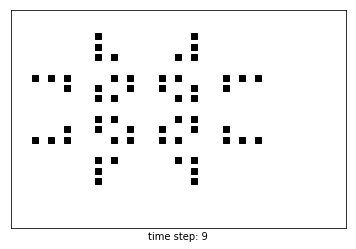

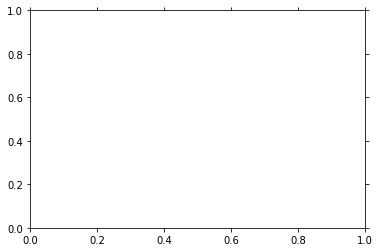

In [3]:
class LifeGame(CellularAutomata2D, ABC):
    def gen_init_state(self) -> np.ndarray:
        init = np.zeros(self.sz_grid)
        init[[1, 1, 2, 2, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
              7, 7, 7, 7, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
              11, 11, 11, 11, 11, 13, 13, 13, 13, 14, 14, 15, 15],
             [5, 11, 5, 11, 5, 6, 10, 11, 1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 3, 5, 7, 9, 11, 13, 5, 6, 10, 11,
              5, 6, 10, 11, 3, 5, 7, 9, 11, 13, 1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 5, 6, 10, 11, 5, 11, 5, 11]] = 1
        return init

    def next_state_single_cell(self, cur_state: np.ndarray, pos: tuple[int, int]) -> int:
        cnt_alive = 0
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if i == 0 and j == 0:
                    continue
                cnt_alive += cur_state[(pos[0] + i) % self.sz_grid[0],
                                       (pos[1] + j) % self.sz_grid[1]]
        return 1 if cnt_alive == 3 else (cur_state[pos[0], pos[1]] if cnt_alive == 2 else 0)

game = LifeGame((20, 20))
game.run(max_iters=10, pause_time=0.1)

### 3.2 例二——$\textbf{NaSch}$ 单车道交通模型

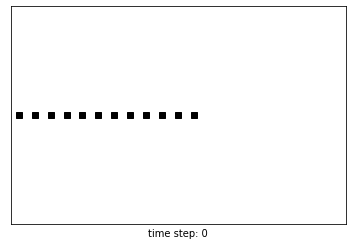

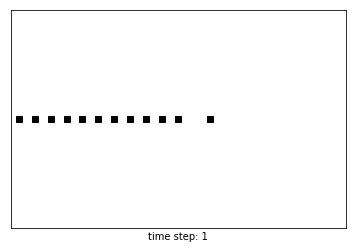

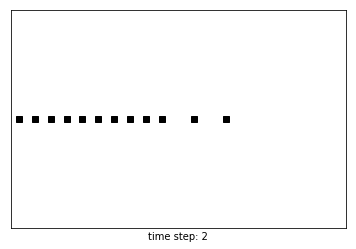

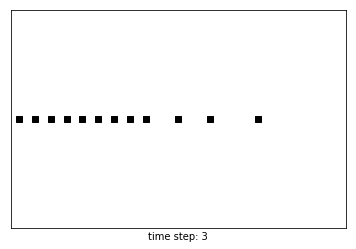

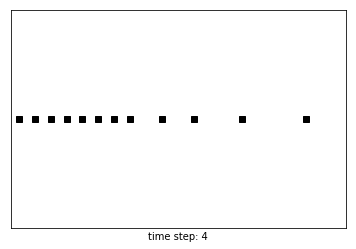

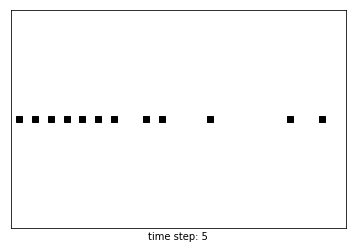

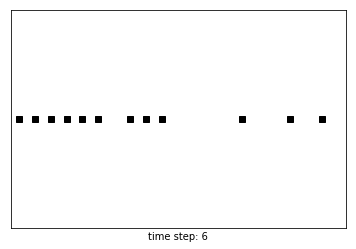

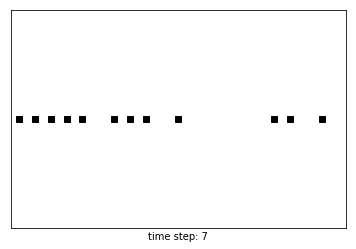

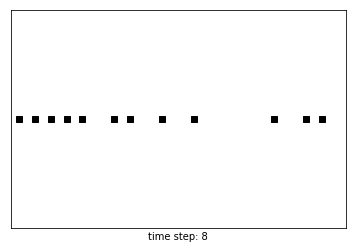

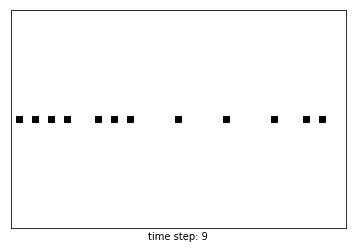

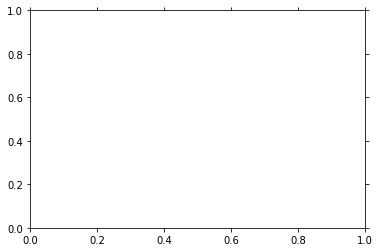

In [4]:
class NaSch(CellularAutomata1D, ABC):
    def __init__(self, sz_grid: int, n_cars: int, vmax: int, p_slow: float) -> None:
        super().__init__(sz_grid)
        self.n_cars = n_cars
        self.vmax = vmax
        self.p_slow = p_slow
        # self.x = np.random.choice(sz_grid, size=n_cars, replace=False)
        # self.x = np.sort(self.x)  # random initialization
        self.x = np.arange(n_cars)  # queue initialization
        self.v = np.zeros(n_cars)

    def gen_init_state(self) -> np.ndarray:
        state = np.zeros(self.sz_grid)
        state[self.x.astype(int)] = 1
        return state

    def next_state_global(self, cur_state: np.ndarray) -> np.ndarray:
        self.v = np.minimum(self.v + 1, self.vmax)
        self.v = np.minimum(self.v, (np.concatenate((self.x[1:], self.x[0:1])) -
                                     self.x + self.sz_grid - 1) % self.sz_grid)
        slow_mask = np.random.rand(self.n_cars) <= self.p_slow
        self.v[slow_mask] = np.maximum(self.v[slow_mask] - 1, 0)
        self.x = (self.x + self.v) % self.sz_grid
        return self.gen_init_state()

nasch = NaSch(sz_grid=20, n_cars=12, vmax=5, p_slow=0.3)
nasch.run(max_iters=10, pause_time=0.1)